# Multi-state complexes

<div class="admonition note">
**Topics**: Complexes, complex reactions.
</div>

In this chapter, we will introduce a concise way of declaring reactions between molecules that can be in a high number of distinct functional states.  We will use the `Complex` class and its subconstituents `SubUnit`s and `SubunitState`s to specify the state space of these molecules.

We will first intoduce `Complex`es in a general way and compare them to other forms of rule-based modeling frameworks. We will then present their use in an IP3 receptor example that builds on the one used in [a previous chapter](STEPS_Tutorial_IP3.ipynb).

## Complex declaration

Complexes are composed of an arbitrary number of subunits that can themselves be in an arbitrary number of states. In this guide, we will represent complexes as collections of geometric shapes, like in the following examples:

<img src="images/complex_examples.png"/>

Each complex consists of a list of subunits, represented by different geometrical shapes in the second column of the figure. These subunits can be in various states (represented by colors), as shown in the third column. Specific instances of complexes can thus be in various states, resulting from all the possible combinations of subunit states. The last column only shows a few examples of such states for each complex.

In order to declare a complex, we first need to declare all its subunits along with their subunit states. We then need to provide a list of subunits that the complex is made of. Consider the following example, corresponding to the first row of the figure:

In [1]:
import steps.interface

from steps.model import *

mdl = Model()

with mdl:
    B0, B1, B2 = SubUnitState.Create()
    
    BSU = SubUnit.Create([B0, B1, B2])
    
    CB = Complex.Create([BSU, BSU, BSU, BSU], statesAsSpecies=True)

As usual, we first need to import required modules and define a `Model` object. The creation of subunit states and subunit is then straighforward with the `SubUnitState` and `SubUnit` classes. `SubUnitState` behaves as `Species`, we do not need to specify any parameters for their creation. `SubUnit` takes a list of `SubUnitState`s as a parameter. Finally, the complex is created with the `Complex` class that takes a list of `SubUnit` objects as argument as well as the `statesAsSpecies` keyword argument that specifies that all states of the complex should be automatically declared in STEPS as `Species`. This keyword parameter is required in the current version of STEPS since multi-state complexes are not natively supported yet.

Note that the list of `SubUnit` objects that is given to the `Complex` constructor can totally contain duplicates since complexes can be composed of several identical subunits. In addition, the order in which the subunits are given is important when these subunits are not identical as it will later be used to identify specific subunits in a complex. In our graphical representations, we will assume that the first element of this list is the subunit in the top right corner of the complex and the remaning subunits are read in clockwise order from there.

We can then list all the states that this complex can be in with:

In [2]:
def printStates(cs):
    print(f'{len(cs)} states')
    for state in cs:
        print(state)
        
printStates(CB[...])

15 states
CB[B0, B0, B0, B0]
CB[B0, B0, B0, B1]
CB[B0, B0, B0, B2]
CB[B0, B0, B1, B1]
CB[B0, B0, B1, B2]
CB[B0, B0, B2, B2]
CB[B0, B1, B1, B1]
CB[B0, B1, B1, B2]
CB[B0, B1, B2, B2]
CB[B0, B2, B2, B2]
CB[B1, B1, B1, B1]
CB[B1, B1, B1, B2]
CB[B1, B1, B2, B2]
CB[B1, B2, B2, B2]
CB[B2, B2, B2, B2]


We used the square bracket notation after the complex name to access its states: `CB[...]`. This notation returns an object that describes a set of states of the complex, when using it only with the ellipsis `...` object, this corresponds to all possible states of the complex. We will see how to use this notation later in the chapter.

Note that instead of the $3^4 = 81$ states that should result from all possible combinations of 3 subunit states for 4 subunits, we only have 15 states. This is due to the fact that, by default, complex states do not take the order of subunits into account. The state `CB_B0_B0_B0_B1` is equivalent to the state `CB_B0_B0_B1_B0` since they are both composed of 3 subunits in state `B0` and one subunit in state `B1`. Only one of the four equivalent states is conserved and declared in STEPS as a `Species`.

### Complex ordering

This behavior is however not always desirable as neighboring relations between subunits can sometimes be considered important. The `Complex` constructor can thus take an additional keyword argument `order`. This argument makes it possible to specify groups of complex states that will be considered equivalent. STEPS comes with 3 built-in choices for this parameter: `NoOrdering`, the default ; `StrongOrdering`, that considers all possible ordered states ; and `RotationalSymmetryOrdering`, that we will explain below. It is also possible to implement a custom order function, more details are given in [the documentation](API_model.rst#steps.API_2.model.Complex).

The following figure shows how states are grouped in the 3 order functions for a complex with 4 identical subunits with 2 states:

<img src="images/complex_states_1.png"/>

Columns correspond to the number of subunits in state S1 (dark blue), starting with all subunits in state S0 (light blue). The last two columns are ommited since they are identical to the first two if states are inverted. Grey lines represent which states are grouped together under the different ordering functions. The first row contains all the possible ordered states and the last one contains the unordered states. Since subunits can only be in two states, there are only 5 states under the `NoOrdering` function: all subunits in S0, one subunit in S1, two in S1, etc. The `RotationalSymmetryOrdering` function is a bit trickier, it groups all states that are identical under rotation. When only one subunit is in S1, all states can be made equivalent with quarter turn rotations. This is not the case when two subunits are in S1, there are then two distinct states that cannot be made identical with quarter turn rotations: a state in which the two subunits in S1 are adjacent, and another in which they are opposite. Note that this rotational symmetry still takes into account handedness:

<img src="images/complex_states_2.png"/>

In the above figure, 4 identical subunits can be in 3 different states and we only consider the case in which two subunits are in S0 (light blue), one in S1 (dark blue) and one in S2 (teal). Note that under rotational symmetry, there are two complex states in which S1 and S2 are adjacent but these states are not identical: the left one has S1 then S2 while the other has S2 then S1 (in clockwise direction). When complexes contain different subunits, and depending in which order the subunits are declared in the complex, it becomes less likely for complex states to be rotationaly equivalent:

<img src="images/complex_states_3.png"/>

We can declare the complex described in this last figure in STEPS with the rotational symmetry ordering function:

In [3]:
with mdl:
    C0, C1, R0, R1 = SubUnitState.Create()
    
    CSU, RSU = SubUnit.Create([C0, C1], [R0, R1])
    
    CC = Complex.Create(
        [CSU, RSU, CSU, RSU], statesAsSpecies=True, order=RotationalSymmetryOrdering
    )

We can then print all the corresponding states:

In [4]:
printStates(CC[...])

10 states
CC[C0, R0, C0, R0]
CC[C0, R0, C0, R1]
CC[C0, R0, C1, R0]
CC[C0, R0, C1, R1]
CC[C0, R1, C0, R1]
CC[C0, R1, C1, R1]
CC[C1, R0, C0, R1]
CC[C1, R0, C1, R0]
CC[C1, R0, C1, R1]
CC[C1, R1, C1, R1]


We get 10 states, as expected from the figure. Again, we used the square bracket notation `CC[...]` to access complex states ; in the next section, we describe how this notation works.

## Complex selectors

A complex selector is an instance of the `ComplexSelector` class and is created when using the square bracket notation on a complex. Simply put, the square bracket notation allows to slice the complex state space in a way that is similar to array slicing in numpy (see [the numpy documentation](https://numpy.org/doc/1.18/reference/arrays.indexing.html) for more details). As we will see later, these complex selectors can then be used for declaring reactions that apply to a subset of complex states without having to enumerate all the states. The following figure shows how various square bracket notations select various part of the complex state space:

<img src="images/complex_selectors.png"/>

For simplicity of representation, the complex used in these examples has 3 subunits: two identical subunits `S` and one subunit `T`, both these subunits can be in 3 different states. The same principles of course apply for complexes with more than 3 subunits. While in these examples, the full ordered state space is represented, the complex states selected by a complex selectors will depend on the specific ordering function used during the creation of the `Complex`. The states are organized spatially as if they were part of a three dimensional matrix, to make the analogy with numpy slicing easier to see.

Let us declare this complex in STEPS and evaluate these complex selectors:

In [5]:
with mdl:
    S0, S1, S2, T0, T1, T2 = SubUnitState.Create()
    
    SSU, TSU = SubUnit.Create([S0, S1, S2], [T0, T1, T2])
    
    CD = Complex.Create([SSU, SSU, TSU], statesAsSpecies=True, order=StrongOrdering)

The first example **A** corresponds to the complex selector we used so far, it returns all the possible states of the complex. Like for numpy slicing, the easiest way to select all 'dimensions' from the complex is to use a colon `:` for each dimension, meaning we want to select everything in this 'dimension'. The complex has 3 subunits / 'dimensions' so we need 3 colons in the square bracket: `CD[:, :, :]`. The order of dimensions is the same as the one used when declaring the complex. The ellipsis object `...` can be used, like in numpy, to avoid repeating colons when the number of subunits / dimensions is high. It is equivalent to typing comma separated colons for the remaning dimensions. Note however that only one ellipsis object can be used in a square bracket notation since using several could lead to ambiguities (in `CD[..., S0, ...]` it would not be clear which dimension should correspond to S0). If no ellipsis object is used, the number of comma separated values should always match the number of subunits in the complex.

We can thus get all $3^3 = 27$ complex states with:


In [6]:
printStates(CD[...])

27 states
CD[S0, S0, T0]
CD[S0, S0, T1]
CD[S0, S0, T2]
CD[S0, S1, T0]
CD[S0, S1, T1]
CD[S0, S1, T2]
CD[S0, S2, T0]
CD[S0, S2, T1]
CD[S0, S2, T2]
CD[S1, S0, T0]
CD[S1, S0, T1]
CD[S1, S0, T2]
CD[S1, S1, T0]
CD[S1, S1, T1]
CD[S1, S1, T2]
CD[S1, S2, T0]
CD[S1, S2, T1]
CD[S1, S2, T2]
CD[S2, S0, T0]
CD[S2, S0, T1]
CD[S2, S0, T2]
CD[S2, S1, T0]
CD[S2, S1, T1]
CD[S2, S1, T2]
CD[S2, S2, T0]
CD[S2, S2, T1]
CD[S2, S2, T2]


Examples **B** and **C** slice the state space in one dimension. The complex selector in example **B** has colons for the first two dimensions, meaning all subunit states are selected, and the last one has the `T1` `SubUnitState` object, indicating that only complex states in which the third subunit is in state `T1` should be selected. Again, the two colons can be replaced by an ellipsis object `...`.

In [7]:
printStates(CD[:, :, T1])

9 states
CD[S0, S0, T1]
CD[S0, S1, T1]
CD[S0, S2, T1]
CD[S1, S0, T1]
CD[S1, S1, T1]
CD[S1, S2, T1]
CD[S2, S0, T1]
CD[S2, S1, T1]
CD[S2, S2, T1]


Example **D** specifies two out of three dimensions, it selects all states in which the second `S` subunit is in state `S1` and the `T` subunit is in state `T1`. Note that if all subunits / 'dimensions' are uniquely specified, the square bracket notation returns a `ComplexState` instead of a `ComplexSelector`. As expected example **D** return 3 states:

In [8]:
printStates(CD[:, S1, T2])

3 states
CD[S0, S1, T2]
CD[S1, S1, T2]
CD[S2, S1, T2]


Example **E** combines two `SubUnitState` with the union operator `|` in order to select states for which the first subunit is either in state `S0` or `S2`. Alternatively, since there are only 3 possibles states for this subunit, we can use the negation operator `~S1` to select all subunit states that are not `S1`:

In [9]:
printStates(CD[S0 | S2, :, T1])
printStates(CD[~S1, :, T1])

6 states
CD[S0, S0, T1]
CD[S0, S1, T1]
CD[S0, S2, T1]
CD[S2, S0, T1]
CD[S2, S1, T1]
CD[S2, S2, T1]
6 states
CD[S0, S0, T1]
CD[S0, S1, T1]
CD[S0, S2, T1]
CD[S2, S0, T1]
CD[S2, S1, T1]
CD[S2, S2, T1]


Not that both `|` and `~` operators return a `SubUnitSelector` object (see [documentation](API_model.rst#steps.API_2.model.SubUnitSelector)) that represent a subset of the `SubUnitState`s associated to a given `SubUnit`.

Examples **F** and **G** illustrate the possibility to combine complex selectors. Example **F** shows the intersection between two result selectors with the `&` operator while example **G** shows the union with the `|` operator. In both cases the result object is a complex selector itself and can thus be further combined with other complex selectors. As expected, the union from example **G** yields 15 states:

In [10]:
printStates(CD[:, :, T1] | CD[:, S1, :])

15 states
CD[S0, S0, T1]
CD[S0, S1, T0]
CD[S0, S1, T1]
CD[S0, S1, T2]
CD[S0, S2, T1]
CD[S1, S0, T1]
CD[S1, S1, T0]
CD[S1, S1, T1]
CD[S1, S1, T2]
CD[S1, S2, T1]
CD[S2, S0, T1]
CD[S2, S1, T0]
CD[S2, S1, T1]
CD[S2, S1, T2]
CD[S2, S2, T1]


Note that, while example **F** can also be written as a single complex selector, example **G** cannot. 

Example **H** illustrates the use of the `<<` operator to inject subunit states in a complex selector. `CD[..] << S0` should be read 'inject a subunit state `S0` in any available position'. Since, in `CD[...]`, there are 2 free positions that can be in state `S0`, it is equivalent to `CD[S0, :, :] | CD[:, S0, :]`. It is not very useful in our example but becomes convenient for bigger complexes. Note that the right hand side of the `<<` operator can also be a `SubUnitSelector`: `CD[...] << (S0 | S1)`. Finally, several subunit states can be injected at once with e.g. `CD[...] << 2 * S0`. Detailed explanations and examples are available in the [documentation](API_model.rst#steps.API_2.model.ComplexSelector). In example **H** we have:

In [11]:
printStates(CD[...] << S0)

15 states
CD[S0, S0, T0]
CD[S0, S0, T1]
CD[S0, S0, T2]
CD[S0, S1, T0]
CD[S0, S1, T1]
CD[S0, S1, T2]
CD[S0, S2, T0]
CD[S0, S2, T1]
CD[S0, S2, T2]
CD[S1, S0, T0]
CD[S1, S0, T1]
CD[S1, S0, T2]
CD[S2, S0, T0]
CD[S2, S0, T1]
CD[S2, S0, T2]


### Complexes and rule based modeling

Although STEPS complexes offer similar capabilities as rule-based modeling frameworks like [bionetgen](http://bionetgen.org/), they are not completely equivalent. STEPS complexes require the explicit declaration of all complexes before any simulation takes place. In contrast, bionetgen allows the creation of new complexes through the binding of smaller complexes. Thus, STEPS complexes are more suited to cases in which the complex has a set structure and its state space is known before simulation.

Having introduced the main concepts relative to the `Complex` class, we can now use multi-state complexes in a full example. We first reset the jupyter kernel to start from scratch:

In [12]:
%reset -f

## IP3 receptor model

The corresponding python script: [STEPS_Tutorial_Complexes.py](https://github.com/CNS-OIST/STEPS_Example/tree/master/user_manual/source/API_2/scripts/STEPS_Tutorial_Complexes.py)

In this section, we will implement the IP3 receptor model described in *De Young and Keizer, A single-pool inositol 1, 4, 5-trisphosphate-receptor-based model for agonist-stimulated oscillations in Ca2+ concentration, PNAS, 1992*. This model relies on a markov chain description of IP3R subunits in which each of the 4 identical subunits have 3 binding sites, one for IP3 and two for Ca2+, one activating, the other inactivating. This results in $2^3 = 8$ possible states per subunit and the whole channel is deemed open if at least three of the subunits are in the state in which one IP3 and the activating Ca2+ are bound. 

We first import the required modules and declare the parameters as specified in the original article:

In [13]:
import steps.interface

from steps.model import *
from steps.geom import *
from steps.sim import *
from steps.saving import *
from steps.rng import *

nAvog = 6.02214076e23 

nbIP3R = 5
nbPumps = 5

c0 = 2e-6
c1 = 0.185

cytVol = 1.6572e-19
ERVol = cytVol * c1

a1 = 400e6
a2 = 0.2e6
a3 = 400e6
a4 = 0.2e6
a5 = 20e6

b1 = 0.13e-6 * a1
b2 = 1.049e-6 * a2
b3 = 943.4e-9 * a3
b4 = 144.5e-9 * a4
b5 = 82.34e-9 * a5

v1 = 6
v2 = 0.11

v3 = 0.9e-6
k3 = 0.1e-6

rp = v3 * 1e3 * cytVol * nAvog / nbPumps / 2
rb = 10 * rp
rf = (rb + rp) / (k3 ** 2)

kip3 = 1e3 * nAvog * ERVol * v1 / nbIP3R

We then declare the model, the species and most importantly, the complex that we will use to simulate IP3 receptors. The following figure describes the IP3R complex:

<img src="images/complex_ip3_structure.png"/>

As explained before, it is composed of 4 identical subunits which can be in 8 distinct states, we name the states according to what is bound to the subunit: for state $ijk$, $i$ is 1 if IP3 is bound, $j$ is 1 if the activating Ca2+ is bound, and $k$ is 1 if the inactivating Ca2+ is bound. State $110$ thus corresponds to the open state. Below the complex and its subunits, we represented the reaction network that governs the transitions between the subunit states. Each transition involves the binding or unbinding of either IP3 or Ca2+.

We then proceed to declaring the IP3R complex:

In [14]:
mdl = Model()
r = ReactionManager()

with mdl:
    Ca, IP3, ERPump, ERPump2Ca = Species.Create()
    
    R000, R100, R010, R001, R110, R101, R111, R011 = SubUnitState.Create()
    
    IP3RSU = SubUnit.Create([R000, R100, R010, R001, R110, R101, R111, R011])
    
    IP3R = Complex.Create([IP3RSU, IP3RSU, IP3RSU, IP3RSU], statesAsSpecies=True)
    
    ssys = SurfaceSystem.Create()

The declaration of the complex itself follows what we saw in the first part of this chapter. We can count the number of distinct complex states:

In [15]:
len(IP3R[...])

330

Note that, since the default ordering is `NoOrdering`, this is much lower than the $8^4=4096$ states that could be expected if `StrongOrdering` was used instead.

The next step is to declare all the reactions involving the IP3R channel. Most of them correspond to IP3 and Ca2+ binding / unbinding that changes the states of subunits. In addition, we also need to write a reaction that will account for the Ca2+ flux from the endoplasmic reticulum (ER) through open IP3R channels. In the following section, we will see how to declare all these reactions.

## Reactions involving complex states

The simplest way to declare a reaction involving a complex consists in simply using a complex state as a reactant in a normal reaction. For example, if we wanted to only allow Ca2+ through the IP3R channel when the four subunits are in the open state, we would write:

```python
with mdl, ssys:
    IP3R[R110, R110, R110, R110].s + Ca.i <r[1]> IP3R[R110, R110, R110, R110].s + Ca.o
    r[1].K = kip3, kip3
```

Both left hand side and right hand side of the reaction contain the `IP3R` complex in a fully specified state. In this case, no changes are made to the complex but there are a lot of cases in which changes to the complex are required. For example, the unbinding of IP3 from one of the subunits of a fully open receptor could be written as:

```python
with mdl, ssys:
    IP3R[R110, R110, R110, R110].s >r[1]> IP3R[R110, R110, R110, R010].s + Ca.o
    r[1].K = rate
```

Note that the specific position of the subunit that is changed does not matter since we declared the complex using the detault `NoOrdering` setting. Complex states are thus used in reactions as if they were `Species`; this is convenient when only a single state of the complex can undergo a specific reaction but it quickly becomes unpractical when several complex states can undergo the same reaction.

If, as is the case in the original De Young Keizer model, the IP3R channel opens when at least 3 subunits are in state `R110`, we would need to declare 8 reactions involving fully specified complex states:

```python
with mdl, ssys:
    IP3R[R110, R110, R110, R000].s + Ca.i <r[1]> IP3R[R110, R110, R110, R000].s + Ca.o
    IP3R[R110, R110, R110, R001].s + Ca.i <r[2]> IP3R[R110, R110, R110, R001].s + Ca.o
    ...
    IP3R[R110, R110, R110, R110].s + Ca.i <r[7]> IP3R[R110, R110, R110, R110].s + Ca.o
    IP3R[R110, R110, R110, R111].s + Ca.i <r[8]> IP3R[R110, R110, R110, R111].s + Ca.o
    r[1].K = kip3, kip3
    ...
    r[8].K = kip3, kip3
```

This case needs to be tackled using complex selectors instead.

## Reactions involving complex selectors

In order to group all these reactions in a single one, we could use the complex selector `IP3R[R110, R110, R110, :]` that encompasses all of the above 8 states. We would intuitively try to declare the reaction like so:

```python
with mdl, ssys:
    IP3R[R110, R110, R110, :].s + Ca.i <r[1]> IP3R[R110, R110, R110, :].s + Ca.o
    r[1].K = kip3, kip3
```
<div class="warning alert alert-block alert-danger">

<b>This raises the following exception</b>: <code>Complex selector IP3R[R110, R110, R110, :] is used in the right hand side of a reaction but is not matching anything in the left hand side and is not fully defined. The reaction is ambiguous.</code>
</div>

When trying to declare the reaction in this way, STEPS throws an exception. This is due to the fact that, in general, STEPS does not know whether the two result selectors refer to the same specific complex or to distinct ones. It is important here to make the distinction between the complex selectors during reaction declaration and the specific complexes that will exist during a simulation. Specific complexes in a simulation are always fully defined while complex selectors are only partially specified. In an actual simulation, specific complexes thus need to be matched to these partially specified objects. 

Although it might not seem very important in the reaction we tried to declare above, it becomes critical when expressing reactions between 2 complexes of the same type. Consider the following reaction using the `CC` complex declared in the first part of this chapter:

```python
CC[:, :, T0] + CC[:, :, T1] >r[1]> CC[:, :, T1] + CC[:, :, T2]
r[1].K = 1
```

This reaction would also result in the same exception being thrown. This reaction happens when two complexes of the same `CC` type meet and when one has its `T` subunit in state `T0` and the other in state `T1`, ignoring the states of the `S` subunits. The intuitive way to read this reaction is that the `T0` complex is changed to `T1` and the `T1` complex is changed to `T2`. It could however be read in a different way: maybe the `T0` complex should be changed to `T2` while the `T1` should remain in `T1`. Imagine for example the specific reaction in which the left hand side is `CC[S0, S0, T0] + CC[S1, S1, T1]`, should the right hand side be `CC[S0, S0, T1] + CC[S1, S1, T2]` or `CC[S0, S0, T2] + CC[S1, S1, T1]`?

In order to make it explicit, STEPS thus requires the user to use identified complexes in reactions involving complex selectors. To get an identified complex in the same example, we would write:

```python
CC_1 = CC.get()
CC_2 = CC.get()
CC_1[:, :, T0] + CC_2[:, :, T1] >r[1]> CC_1[:, :, T1] + CC_2[:, :, T2]
r[1].K = 1
```

Calling the `get()` method on the complex returns an object that behaves like a `Complex` but keeps a specific identity so that, if it appears several times in a reaction, STEPS knows that it refers to the same specific complex. The reaction is now unambiguous and no exceptions are thrown. Coming back to our IP3R channel example, we can now declare the reaction associated to the Ca2+ flux through open IP3R channels with:

In [16]:
with mdl, ssys:
    # Ca2+ passing through open IP3R channel
    IP3R_1 = IP3R.get()
    IP3R_1[R110, R110, R110, :].s + Ca.i <r['caflx']> IP3R_1[R110, R110, R110, :].s + Ca.o
    r['caflx'].K = kip3, kip3


The next step is to somehow declare reactions that are associated to IP3 and Ca2+ binding / unbinding to IP3R subunits, as described in the figure.

Let us first consider all reactions linked to IP3 binding to IP3R subunits and let us specifically focus on IP3 binding to IP3R subunits in the `R000` state, the rate of these reactions will depend on the number of subunits in this state. We can tackle this by writing a complex selector that controls the number of subunits in this state. For example, `IP3R[R000, ~R000, ~R000, ~R000]` corresponds to all states in which only one subunit is in the `R000` state. We could thus write all IP3 binding reactions to `R000` with:

```python
with mdl, ssys:
    IP3R_1 = IP3R.get()
    IP3R_1[R000, ~R000, ~R000, ~R000].s + IP3.o >r[1]> IP3R_1[R100, ~R000, ~R000, ~R000].s
    IP3R_1[R000,  R000, ~R000, ~R000].s + IP3.o >r[2]> IP3R_1[R100,  R000, ~R000, ~R000].s
    IP3R_1[R000,  R000,  R000, ~R000].s + IP3.o >r[3]> IP3R_1[R100,  R000,  R000, ~R000].s
    IP3R_1[R000,  R000,  R000,  R000].s + IP3.o >r[4]> IP3R_1[R100,  R000,  R000,  R000].s
    r[1].K = 1 * a1
    r[2].K = 2 * a1
    r[3].K = 3 * a1
    r[4].K = 4 * a1
```

There are 4 reactions, corresponding to the cases in which the IP3R complex has 1, 2, 3 and 4 subunits in state `R000`. Since there are 4 ways to bind IP3 to an `R000` subunit in a `IP3R[R000, R000, R000, R000]` complex state, the rate of the reaction should be 4 times the elementary rate $a_1$.

Expressing the unbinding reactions is however not trivial using these reactions. Let us consider the first of these 4 reactions, making it reversible would be equivalent to adding the following reaction:

```python
IP3R_1[R100, ~R000, ~R000, ~R000].s >r[1]> IP3R_1[R000, ~R000, ~R000, ~R000].s + IP3.o
```

In contrast with the binding reactions, it is not clear which rate should be used for this reaction, we know that, in the left hand side, at least one subunit is in state `R100` but the other subunits might also be in the same state, it is not prevented by the `~R000` subunit selector. In order to be sure that e.g. only one subunit is in state `R100` we would instead need to write:

```python
IP3R_1[R100, ~R100, ~R100, ~R100].s >r[1]> IP3R_1[R000, ~R100, ~R100, ~R100].s + IP3.o
r[1].K = b1
```

The following tentative solution using a single reversible reaction will **not** work:

```python
IP3R_1[R000, ~R000, ~R000, ~R000].s + IP3.o <r[1]> IP3R_1[R100, ~(R000 | R100), ~(R000 | R100), ~(R000 | R100)].s
r[1].K = a1, b1
```
This reaction is invalid because the right hand side is more restrictive than the left hand side. The left hand side matches e.g. `IP3R[R000, R100, R100, R100]` but the right hand side cannot match it. As a side note, the only way for a right hand side complex selector to be more restrictive is to constrain the subunits to a single state. In this case, there is no ambiguity and the reaction is valid.

We could try to fix this validity issue by using the same subunit selectors on the left hand side:
```python
IP3R_1[R000, ~(R000 | R100), ~(R000 | R100), ~(R000 | R100)].s + IP3.o <r[1]> IP3R_1[R100, ~(R000 | R100), ~(R000 | R100), ~(R000 | R100)].s
r[1].K = a1, b1
```
This is a valid reaction but it does not cover all cases of IP3 binding to an IP3R in which only one subunit is in state `R000`. For example, `IP3R[R000, R100, R111, R111]` would not be taken into account because its second subunit is `R100`, which does not match with the subunit selector `~(R000 | R100)`.

From all these examples, it becomes clear that complex selectors are not well suited to declaring reactions that involve single subunits instead of full complexes. These reactions should instead be declared with their dedicated syntax.

## Reactions involving subunits

In order to express reactions that involve subunits instead of full complexes, we can simply use subunit states as reactants. The IP3 binding reaction to `R000` can thus be declared with:

```python
with mdl, ssys:
    with IP3R[...]:
        R000.s + IP3.o <r[1]> R100.s
        r[1].K = a1, b1
```
The reaction itself corresponds exactly to the reaction being represented on the previous figure. The main difference with the full complex reactions we saw before is that the reaction declaration needs to be done inside a `with` block that uses a complex selector. This specifies the complex on which the reaction applies as well as the states that the complex needs to be in for the reaction to apply. In our case, the reaction applies to IP3R complexes in any state. We do not need to specify that at least one subunit should be in state `R000` since it is already implicitely required by the presence of `R000.s` in the left hand side of the reaction.

Note that, in addition to being much simpler than our previous attempts using complex selectors, this syntax makes it very easy to declare the unbinding reaction ; we just need to make the reaction reversible.

The rates are the per-subunit rates, as in the figure. STEPS will automatically compute the coefficients such that a complex with 2 subunits in state `R000` will undergo the change of one of its subunits with rate $2a_1$. FInally, the position of the complex is indicated by adding the position indicator `.s` to the subunit state itself.

The following figure represents the full complex reactions that are equivalent to 2 examples of subunits reactions:

<img src="images/complex_reactions.png"/>

Note that in both cases, only a very low number of possible reactions are represented. In each case, the required coefficient is applied to the rate that was used in the subunit reaction. For example, the first complex reaction of the left column can happen in four different ways since all four subunits are in the `R000` state; since all these ways result in the same equivalent state `IP3R[R100, R000, R000, R000]`, the subunit reaction rate is multiplied by 4 to get the complex reaction rate. Note that if we used the `StrongOrdering` ordering function, `IP3R[R100, R000, R000, R000]` would be different from e.g. `IP3R[R000, R100, R000, R000]` so four distinct complex reactions with rate $a_1$ would be declared.

### Expressing cooperativity with complex selectors

In our example, subunits bind IP3 and Ca2+ independently ; a simple way to express cooperativity would be to use several `with` blocks with different complex selectors. For example, if the binding rate of IP3 to a `R000` subunit depended on the number of subunits in the `R100` state we could write:

```python
with mdl, ssys:
    # Binding
    with IP3R[~R100, ~R100, ~R100, ~R100]:
        R000.s + IP3.o >r[1]> R100.s
        r[1].K = a1_0
    with IP3R[ R100, ~R100, ~R100, ~R100]:
        R000.s + IP3.o >r[1]> R100.s
        r[1].K = a1_1
    with IP3R[ R100,  R100, ~R100, ~R100]:
        R000.s + IP3.o >r[1]> R100.s
        r[1].K = a1_2
    with IP3R[ R100,  R100,  R100, ~R100]:
        R000.s + IP3.o >r[1]> R100.s
        r[1].K = a1_3
    # Unbinding
    with IP3R[...]:
        R100.s >r[1]> R000.s + IP3.o
        r[1].K = b1
```
With `a1_0` the IP3 binding rate to `R000` when no subunits are in the `R100` state, `a1_1` when one subunit is in this state, etc. Note that the unbinding reaction now needs to be declared separately because, for the `with IP3R[~R100, ~R100, ~R100, ~R100]:` block, the complex selector would be incompatible with the `R100.s` right hand side.

### Expressing cooperativity with complex-dependent reaction rates

There is however a simpler way to express cooperativity by using complex-dependent reaction rate. The following example declares the same reactions as the previous one:

```python
rates = [a1_0, a1_1, a1_2, a1_3]
a1 = CompDepRate(lambda state: rates[state.Count(R100)], [IP3R])

with mdl, ssys:
    with IP3R[...]:
        R000.s + IP3.o <r[1]> R100.s
        r[1].K = a1, b1
```

We first declare a list to hold all our `a1_x` rates ; we then declare the `a1` rate as a `CompDepRate` object. Its constructor (see [documentation](API_model.rst#steps.API_2.model.CompDepRate)) takes two parameters: the first one is a function that takes one or several complex states as parameter and returns a reaction rate ; the second is the list of complexes whose states influence the rate. In our case, the rate only depends on the state of the `IP3R` complex. Since it is possible to declare reactions between two complexes, corresponding rate can be declared with `CompDepRate(lambda state1, state2: ..., [Comp1, Comp2])`. Note that the lambda function now takes two parameters, corresponding to the states of the two complexes. They are given in the same order as in the `[Comp1, Comp2]` list.

Note that the lambda function in the `CompDepRate` constructor makes uses of the `Count` method (see [documentation](API_model.rst#steps.API_2.model.ComplexState.Count)) from the `ComplexState` class. This method takes a `SubUnitState` or a `SubUnitSelector` as a parameter and returns the number of subunits in the state that correspond to the one passed as parameter.

The reaction can then be declared inside a `with IP3R[...]` block, meaning it applies to all complexes, no matter their state. The forward rate is then simply set to the `CompDepRate` object we declared.

Declaring reactions involving subunits can be done in a lot of different ways. We covered the most common cases in the previous subsections and advanced use cases are treated in [a separate section](#Advanced-use-of-subunit-reactions), as appendix to this chapter.

Let us now come back to our main IP3R simulation example and declare the missing reactions:

In [17]:
with mdl, ssys:

    # IP3R subunits reaction network
    with IP3R[...]:
        R000.s + IP3.o <r[1]> R100.s
        R000.s + Ca.o <r[2]> R010.s
        R000.s + Ca.o <r[3]> R001.s

        R100.s + Ca.o <r[4]> R110.s
        R100.s + Ca.o <r[5]> R101.s

        R010.s + IP3.o <r[6]> R110.s
        R010.s + Ca.o <r[7]> R011.s

        R001.s + IP3.o <r[8]> R101.s
        R001.s + Ca.o <r[9]> R011.s

        R110.s + Ca.o <r[10]> R111.s
        R101.s + Ca.o <r[11]> R111.s

        R011.s + IP3.o <r[12]> R111.s

        r[1].K = a1, b1
        r[2].K = a5, b5
        r[3].K = a4, b4
        r[4].K = a5, b5
        r[5].K = a2, b2
        r[6].K = a1, b1
        r[7].K = a4, b4
        r[8].K = a3, b3
        r[9].K = a5, b5
        r[10].K = a2, b2
        r[11].K = a5, b5
        r[12].K = a3, b3

    # Ca2+ leak
    Ca.i <r[1]> Ca.o
    r[1].K = v2, c1 * v2

    2*Ca.o + ERPump.s <r[1]> ERPump2Ca.s >r[2]> 2*Ca.i + ERPump.s
    r[1].K = rf, rb
    r[2].K = rp

The full subunit reaction network is declared in the `with IP3R[...]:` block. The remaining lines declare the reactions associated to the Ca2+ leak from the endoplasmic reticulum (ER) as well as the Ca2+ pumping into the ER.

## Geometry and simulation

The well-mixed geometry is declared easily with:

In [18]:
geom = Geometry()

with geom:
    cyt, ER = Compartment.Create()
    cyt.Vol = cytVol
    ER.Vol = ERVol

    memb = Patch.Create(ER, cyt, ssys)
    memb.Area = 0.4143e-12

As in other chapters, we then declare the simulation object as well as the data to be saved:

In [19]:
rng = RNG('mt19937', 512, 7233)

sim = Simulation('Wmdirect', mdl, geom, rng)

rs = ResultSelector(sim)

cytCa = rs.cyt.Ca.Conc

caFlux = rs.SUM(rs.memb.caflx['fwd'].Extent) << rs.SUM(rs.memb.caflx['bkw'].Extent)

IP3RStates =   rs.memb.IP3R[~R110, ~R110, ~R110, ~R110].Count
IP3RStates <<= rs.memb.IP3R[ R110, ~R110, ~R110, ~R110].Count
IP3RStates <<= rs.memb.IP3R[ R110,  R110, ~R110, ~R110].Count
IP3RStates <<= rs.memb.IP3R[ R110,  R110,  R110, ~R110].Count
IP3RStates <<= rs.memb.IP3R[ R110,  R110,  R110,  R110].Count

sim.toSave(cytCa, caFlux, IP3RStates, dt=0.05)

Model checking:
No errors were found


Both `cytCa` and `caFlux` result selectors use syntaxes that were already presented in the previous chapters. Note however that we use `rs.SUM()` on `caFlx` paths because `rs.memb.caflx['fwd'].Extent` saves the extents of all reactions that are implied by the `'caflx'` complex reaction. Since we want to look at the overall complex reaction extent, we sum these values with `rs.SUM()`.

The data saving relative to complexes themselves is new but relatively easy to understand. In our example, we want to track how receptors are distributed in terms of number of subunits in the `R110` open state. We save 5 values: the number of `IP3R` that have 0 subunits in the `R110` state, the number of `IP3R` that have 1 subunit in this state, etc. Note that the `rs.memb.IP3R.Count` result selector would save the total number of `IP3R` on the ER membrane.

In addition to counting numbers of complexes, it is also possible to count numbers of subunits. `rs.memb.IP3R.R110.Count` would save the total number of subunits of `IP3R` that are in state `R110`.

Finally, if one wanted to save the separate counts of all states matching some complex selectors, one could use `rs.memb.LIST(*IP3R[R110, R110, ...]).Count`. This uses the `LIST()` function that we saw in previous chapters by feeding it all the states that we want to save.

We can then proceed to setting up intial conditions and running the simulation:

In [20]:
ENDT = 10.0

sim.newRun()

# Initial conditions
sim.cyt.Ca.Conc = 3.30657e-8
sim.cyt.IP3.Conc = 0.2e-6
sim.ER.Ca.Conc = c0/c1
sim.memb.ERPump.Count = nbPumps
sim.memb.IP3R[R000, R000, R000, R000].Count = nbIP3R

sim.run(ENDT)

Note that injecting `IP3R` complexes requires specifying their states completely.

## Plotting the results

We then plot the results from the `cytCa` and `caFlux` result selectors first:

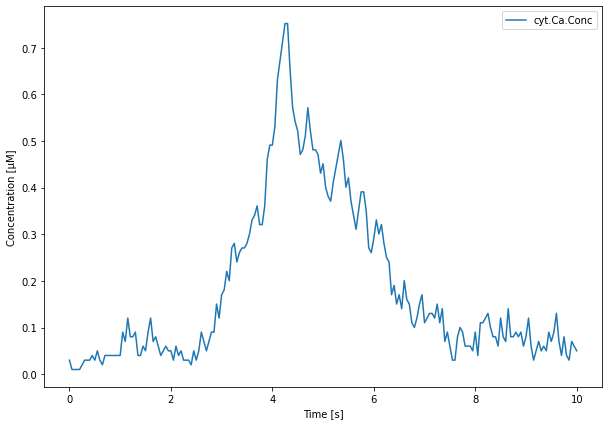

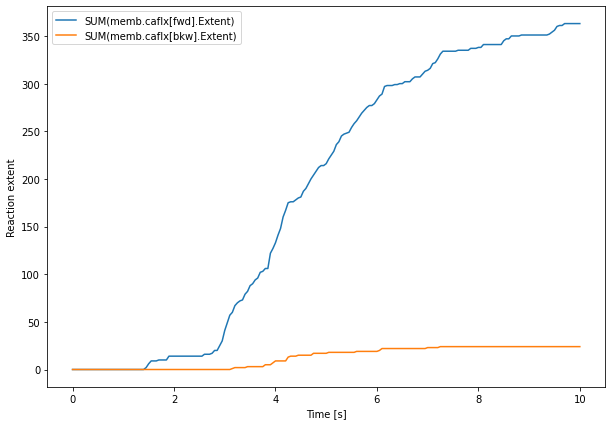

In [21]:
from matplotlib import pyplot as plt
import numpy as np

plt.figure(figsize=(10, 7))
plt.plot(cytCa.time[0], cytCa.data[0]*1e6)
plt.legend(cytCa.labels)
plt.xlabel('Time [s]')
plt.ylabel('Concentration [μM]')
plt.show()

plt.figure(figsize=(10, 7))
plt.plot(caFlux.time[0], caFlux.data[0])
plt.legend(caFlux.labels)
plt.xlabel('Time [s]')
plt.ylabel('Reaction extent')
plt.show()

We then plot the data from the `IP3RStates` result selector. In addition to the raw data, we compute a sliding window average to ease visualization:

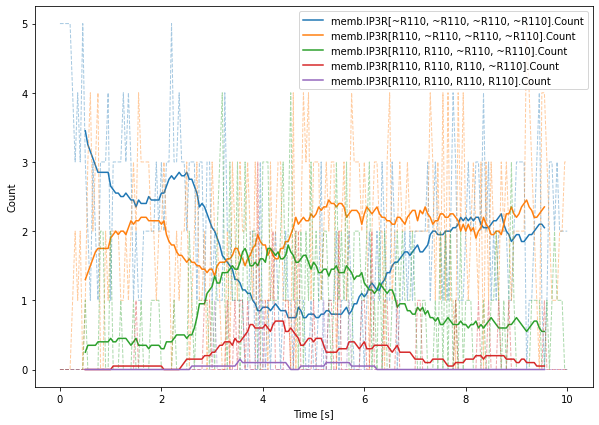

In [22]:
n = 20

plt.figure(figsize=(10, 7))
for i in range(IP3RStates.data[0].shape[1]):
    sig = IP3RStates.data[0, :, i]
    avg = np.convolve(sig, np.ones(n) / n, 'valid')
    tme = IP3RStates.time[0, n//2:-n//2+1]
    
    plt.plot(tme, avg, color=f'C{i}', label=IP3RStates.labels[i])
    plt.plot(IP3RStates.time[0], sig, '--', linewidth=1, color=f'C{i}', alpha=0.4)

plt.legend(loc=1)
plt.xlabel('Time [s]')
plt.ylabel('Count')
plt.show()

## Advanced use of subunit reactions

This subsection presents advanced use of complexes and can thus easily be skipped by a first-time reader.

### Reactions between two complexes

In our main example, we only ever declared subunit reactions with a single complex. It is however possible to declare reactions that involve two complexes ; let us take complexes `CB` and `CC` (from the first part of this chapter) as examples and let us declare a reaction between subunit state `B1` from `CB` and subunit state `R0` from `CC`:

```python
with CB[...], CC[...]:
    B1 + R0 <r[1]> B2 + R1
    r[1].K = r_f, r_b
```

The only difference with the reactions that we declared in the main example is that the `with` block now contains two complex selectors, one per complex, separated by a comma. As for single complex reactions, the rates `r_f` and `r_b` are multiplied by the required coefficents when necessary. For example the complex state `CB[B1, B1, B1, B1]` reacts with the complex state `CC[C0, R0, C0, R0]` with a rate equal to $4 \times 2 r_f = 8 r_f$ since there are 8 ways to have a reaction between one `B1` and one `R0`.

Since `B1`, `B2`, `R0`, and `R1` are unambiguously associated to their respective complex, nothing more is necessary for this reaction. In some cases, like when a reaction occurs between two complexes of the same type, it is however necessary to specify which subunit state belongs to which complex:

```python
with CB[...] as C1, CB[...] as C2:
    B0[C1] + B1[C2] >r[1]> B1[C1] + B2[C2]
    r[1].K = r_f
```

Here we defined a reaction between two `CB` complexes ; in order to differentiate them, we need to give them different names by using the `as` python notation. Inside the `with` block, one of them will be called `C1` and the other `C2`. Then, when we declare the reaction betweem subunit states, we specify which complex the subunit state is attached to by using square brackets : `B0[C1]` represents a subunit from complex `C1` in state `B0`.

As long as only one subunit per complex is involved in the reaction, this allows to lift any ambiguities. We are however faced with an issue when trying to declare a reaction in which several subunits from the same complex are involved:

```python
with CB[...]:
    B0 + B1 >r[1]> B1 + B2
    r[1].K = r_f
```

Like in the case we mentioned in the [complex selectors section](#Reactions-involving-complex-selectors), it is not clear whether `B0` should become `B1` and `B1` should become `B2` or if `B0` should become `B2` and `B1` should stay `B1`.

### Subunit state identifiers

This ambiguity can be lifted with subunit state identifiers:

```python
with CB[...]:
    B0['a'] + B1['b'] >r[1]> B1['a'] + B2['b']
    r[1].K = r_f
```

We again use the square bracket notation to add information to a subunit state but this time we give a string that identifies the subunit. This reaction is now unambiguous: the `'a'` subunit goes from `B0` to `B1` while the `'b'` subunit goes from `B1` to `B2`.

Note that it is possible to combine subunit identifiers with complex identifiers:

```python
with CB[...] as C1, CB[...] as C2:
    B0[C1, 'a'] + B1[C1, 'b'] + B2[C2] >r[1]> B1[C1, 'a'] + B2[C1, 'b'] + B2[C2]
    r[1].K = r_f
```

This declares a reaction between two `CB` complexes identified as `C1` and `C2`. `C1` needs to have one subunit identified as `'a'` in state `B0` and another subunit identified as `'b'` in state `B1` while `C2` contains one subunit in state `B2`. The reaction transforms subunit `'a'` to `B1`, `'b'` to `B2`, and leaves `B2` from complex `C2` unchanged.

Note that this reaction involved two subunits from the same specific complex. When `C1` is in state `CB[B0, B0, B1, B1]` and `C2` in state `CB[B2, B2, B2, B2]` the reaction between these two complexes occurs with rate $2 \times 2 \times 4 r_f = 16 r_f$ because there are 4 ways to select a pair of `B0`, `B1` subunits from `C1` and 4 ways to select a `B2` from `C2`.

As a side note, when the [verbosity](API_utils.rst#steps.API_2.utils.SetVerbosity) is set higher or equal to 3, all the reactions that are implied by a complex reactions are displayed along with their respective rates. Users should check these reactions in order to be sure that they correspond to what they intended.

### Subunit selectors

As we saw earlier, it is possible to combine subunit states with the `|` or `~` operators to obtain `SubUnitSelector` objects that represent several subunit states from a single subunit. These subunit selectors can also be used in reactions:

```python
with CB[...]:
    ~B0 >r[1]> B0
    r[1].K = r_f
```

Since the subunits from `CB` can only be in states `B0`, `B1`, or `B2`, this reaction is equivalent to the two following reactions:
```python
with CB[...]:
    B1 >r[1]> B0
    B2 >r[2]> B0
    r[1].K = r_f
    r[2].K = r_f
```

The same reactions can be expressed with:

```python
with CB[...]:
    (B1|B2) >r[1]> B0
    r[1].K = r_f
```

Note that the `B1|B2` subunit selector is wrapped in parentheses. In this specific example it is not really necessary but it is advised to always wrap subunit selectors in parentheses when used in reaction declaration in order to avoid issues with operator precedence. `B1|B2 >r[1]> B0` works but `B1|B2 + B0 >r[1]> 2*B0` would throw an exception because the `+` operator has priority over `|`. It would thus be interpreted by default as `B1 | (B2 + B0) >r[1]> 2*B0` instead of the correct `(B1|B2) + B0 >r[1]> 2*B0`.